# Clustering Comparison: Leiden vs Louvain

In [1]:
import os
import bokeh
from bokeh.plotting import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phenograph
import pacmap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import flowkit as fk

bokeh.io.output_notebook()
%matplotlib inline

Loading BokehJS ...

### Load Samples & FlowJo 10 workspace

In [2]:
base_dir = "../../../data/8_color_data_set/"
sample_path = os.path.join(base_dir, "fcs_files")
wsp_path = os.path.join(base_dir, "8_color_ICS.wsp")

seed = 123

In [3]:
workspace = fk.Workspace(wsp_path, fcs_samples=sample_path)

In [4]:
sample_groups = workspace.get_sample_groups()
sample_groups

['All Samples', 'DEN', 'GEN', 'G69', 'Lyo Cells']

In [5]:
sample_group = 'DEN'

In [6]:
sample_ids = workspace.get_sample_ids()
sample_ids

['101_DEN084Y5_15_E01_008_clean.fcs',
 '101_DEN084Y5_15_E03_009_clean.fcs',
 '101_DEN084Y5_15_E05_010_clean.fcs']

In [7]:
sample_id = '101_DEN084Y5_15_E01_008_clean.fcs'

In [8]:
print(workspace.get_gate_hierarchy(sample_id, output='ascii'))

root
╰── Time
    ╰── Singlets
        ╰── aAmine-
            ╰── CD3+
                ├── CD4+
                │   ├── CD107a+
                │   ├── IFNg+
                │   ├── IL2+
                │   ╰── TNFa+
                ╰── CD8+
                    ├── CD107a+
                    ├── IFNg+
                    ├── IL2+
                    ╰── TNFa+


### Run analyze_samples & retrieve gated events as DataFrames

Knowing how to process data for dimension reduction and clustering algorithms will tend to yield better results. A crucial step is removing data not relevant to the cell populations of interest. 

In our example using PBMC data, let's say we are targeting the difference in cytokine expression between CD4+ and CD8+ cells. In this case, any doublets or dead cells would be unwanted cell populations not relevant to our analysis. We can use FlowKit to extract the single live cells.

We can further improve the results by filtering unneeded columns. Because we intend to use the filtered data of live single cells, we don't need the scatter channels or the AquaAmine channel used for live/dead discrimination. The Time channel can be ignored as well.

Finally, there is subsampling. This not only reduces the total amount of data to process, but also balances the contributions from each subject sample. One or more samples could have significantly more cells acquired or have an overabundance of cells expressing a particular marker or set of markers. By balancing the contribution of data from each sample via subsampling we can avoid a bias due to these issues. However, it is important to use a subsample count above the frequency of the cell populations of interest (e.g. the cytokine markers in this case).

Using our knowledge of the data set to preprocess data can significantly improve the results of using dimension reduction and clustering algorithms. These steps can also help make sense of the output. Because we reduced the data set to the live single cells and know we are targeting the CD4 vs CD8 populations, we can expect to see 2 or 3 major populations emerge (CD4+, CD8+, and cells in neither).

In [9]:
# Analyze the samples before extracting the gated population
workspace.analyze_samples(sample_group)

In [10]:
# Extract the aAmine- (live single cells)
dfs = []
for sample_id in sample_ids:
    df = workspace.get_gate_events(sample_id, gate_name="aAmine-")
    dfs.append(df)

In [11]:
# check our cell counts per sample
[df.shape for df in dfs]

[(164655, 16), (161823, 16), (160955, 16)]

In [12]:
# review the columns
dfs[0].head()

,sample_id,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,TNFa FITC FLR-A,CD8 PerCP-Cy55 FLR-A,IL2 BV421 FLR-A,Aqua Amine FLR-A,IFNg APC FLR-A,CD3 APC-H7 FLR-A,CD107a PE FLR-A,CD4 PE-Cy7 FLR-A,Time
6,101_DEN084Y5_15_E01_008_clean.fcs,0.632765,0.519402,0.304564,0.116014,0.111382,0.260397,0.253992,0.225618,0.253962,0.250438,0.235338,0.419341,0.276203,0.548099,0.036353
7,101_DEN084Y5_15_E01_008_clean.fcs,0.428379,0.338997,0.315916,0.205931,0.192833,0.266981,0.241998,0.240605,0.328635,0.248555,0.241893,0.240895,0.283410,0.256122,0.036381
9,101_DEN084Y5_15_E01_008_clean.fcs,0.415333,0.329010,0.315593,0.200316,0.182648,0.274184,0.254298,0.329108,0.320049,0.257477,0.271226,0.500196,0.319537,0.594672,0.036452
10,101_DEN084Y5_15_E01_008_clean.fcs,0.427080,0.328156,0.325364,0.296132,0.262680,0.281837,0.260209,0.296330,0.316296,0.262380,0.266253,0.451234,0.284111,0.618065,0.036467
11,101_DEN084Y5_15_E01_008_clean.fcs,0.701165,0.573032,0.305901,0.161239,0.150318,0.268163,0.260474,0.573255,0.238638,0.252554,0.237368,0.358040,0.291882,0.256663,0.036481


In [13]:
dfs[0].columns

Index(['sample_id', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W',
       'TNFa FITC FLR-A', 'CD8 PerCP-Cy55 FLR-A', 'IL2 BV421 FLR-A',
       'Aqua Amine FLR-A', 'IFNg APC FLR-A', 'CD3 APC-H7 FLR-A',
       'CD107a PE FLR-A', 'CD4 PE-Cy7 FLR-A', 'Time'],
      dtype='object')

In [14]:
# define our columns of interest
cols_of_interest = [
    'CD3 APC-H7 FLR-A',
    'CD4 PE-Cy7 FLR-A',
    'CD8 PerCP-Cy55 FLR-A', 
    'CD107a PE FLR-A', 
    'IFNg APC FLR-A', 
    'IL2 BV421 FLR-A',
    'TNFa FITC FLR-A'
]

In [15]:
# subsample 10k events and filter by columns of interest
k = 10_000
X = pd.concat([df[cols_of_interest].sample(k) for df in dfs])

In [16]:
X.head()

,CD3 APC-H7 FLR-A,CD4 PE-Cy7 FLR-A,CD8 PerCP-Cy55 FLR-A,CD107a PE FLR-A,IFNg APC FLR-A,IL2 BV421 FLR-A,TNFa FITC FLR-A
146715,0.289644,0.223953,0.347949,0.263591,0.242923,0.298910,0.254315
142818,0.544774,0.608219,0.242794,0.303559,0.253360,0.312926,0.243154
133177,0.438623,0.240236,0.608527,0.248457,0.224819,0.252084,0.254174
108758,0.498806,0.612880,0.272796,0.284676,0.237373,0.269341,0.242340
69791,0.464877,0.311610,0.623663,0.288286,0.260586,0.311866,0.247077


### Perform Louvain & Leiden clustering

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
communities_louvain, graph_louvain, Q_louvain = phenograph.cluster(
    X_scaled, 
    clustering_algo='louvain', 
    seed=seed,
    k=100,  # choose your own k-neighbors (default=30)
    resolution_parameter=0.5  # choose your own res param (default=1.0)
)

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 3.392627477645874 seconds
Jaccard graph constructed in 5.198356628417969 seconds
Wrote graph to binary file in 0.7641251087188721 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.780179
After 3 runs, maximum modularity is Q = 0.781555
After 5 runs, maximum modularity is Q = 0.785849
Louvain completed 25 runs in 39.50225257873535 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 49.342182636260986 seconds


In [19]:
# check the number of clusters for louvain
np.unique(communities_louvain).shape[0]

12

In [20]:
communities_leiden, graph_leiden, Q_leiden = phenograph.cluster(
    X_scaled, 
    clustering_algo='leiden',
    seed=seed,
    k=100,  # choose your own k-neighbors (default=30)
    resolution_parameter=0.5  # choose your own res param (default=1.0)
)

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.628049373626709 seconds
Jaccard graph constructed in 5.568854093551636 seconds
Running Leiden optimization
Leiden completed in 22.503085374832153 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 32.50344252586365 seconds


In [21]:
# check the number of clusters for leiden
np.unique(communities_leiden).shape[0]

7

In [22]:
titles = ['Leiden', 'Louvain']
communities = [communities_leiden, communities_louvain]

In [23]:
leiden_means = [
    X_scaled[communities_leiden==i, :].mean(axis=0)
    for i in np.unique(communities_leiden)
]
leiden_clusters = pd.DataFrame(
    leiden_means, 
    columns = X.columns, 
    index=np.unique(communities_leiden)
)
leiden_clusters.index.name = 'Cluster'

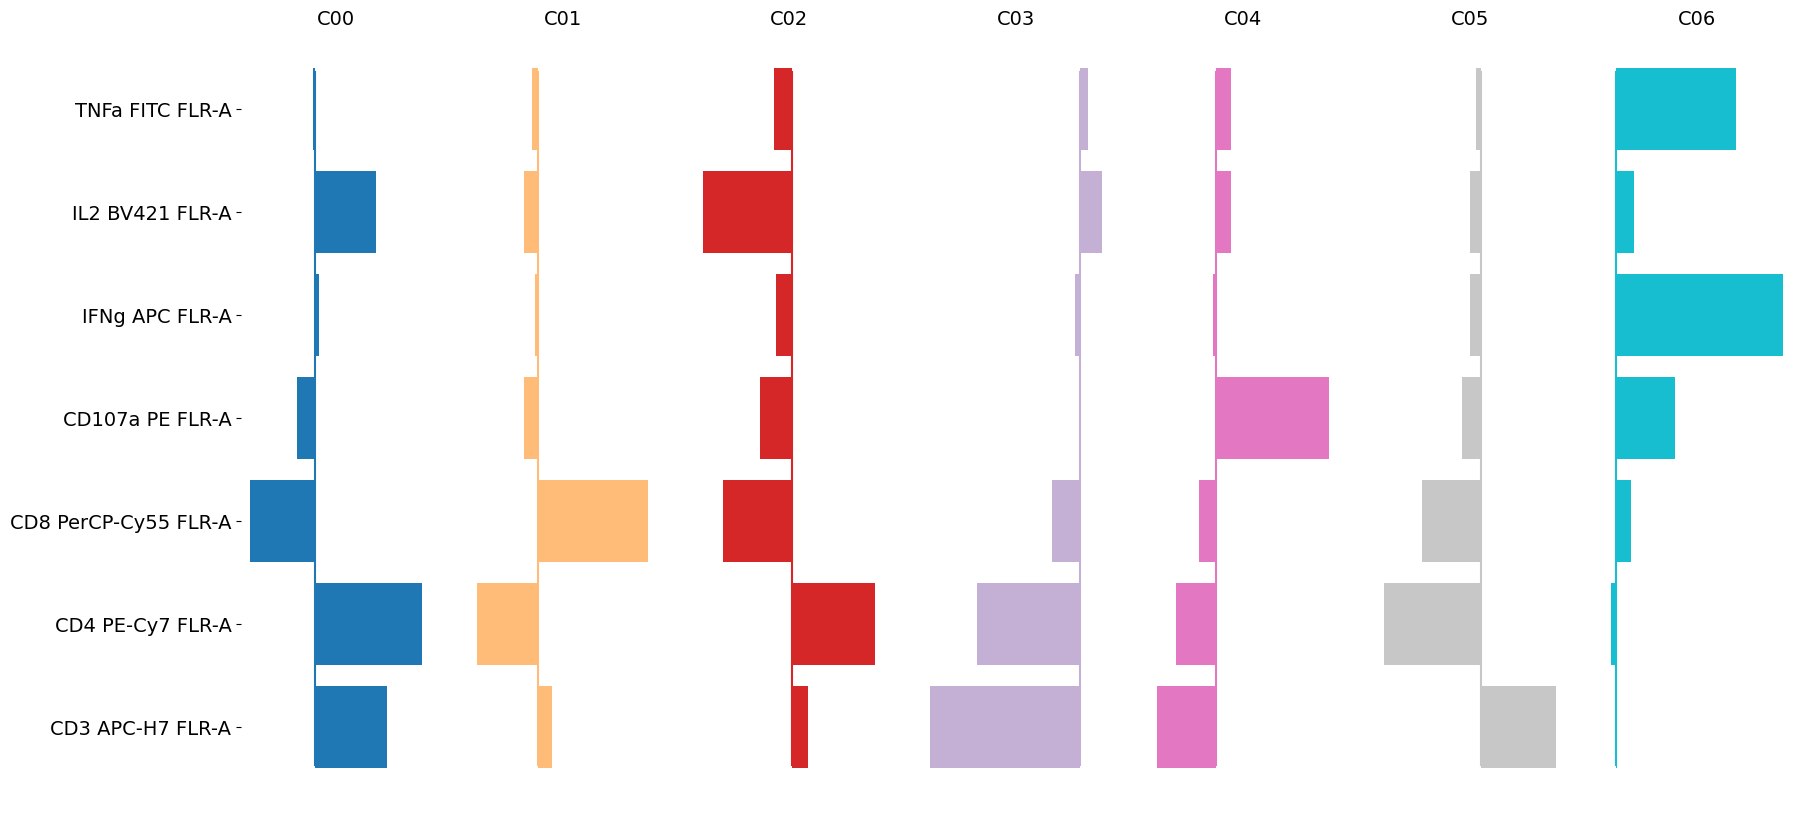

In [24]:
tab20 = plt.colormaps['tab20']
n, p = leiden_clusters.shape

fig, axes = plt.subplots(1, n, figsize=(20, 10))

for i, ax in enumerate(axes.ravel()):
    ax.barh(range(p), leiden_clusters.iloc[i,:], color=tab20(int(i*(20+1)/n)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_title(f'C{i:02d}', fontsize=14)
    ax.axvline(0, c=tab20(int(i*(20+1)/n)), ymin=0.05, ymax=0.95)
    
    if i == 0:
        ax.set_yticks(range(p))
        ax.set_yticklabels(leiden_clusters.columns,fontsize=14)

### Apply dimension reduction using PaCMAP

In [25]:
embedder = pacmap.PaCMAP()

In [26]:
X2 = embedder.fit_transform(X_scaled)

In [27]:
min_max_scaler = MinMaxScaler()
X2 = min_max_scaler.fit_transform(X2)

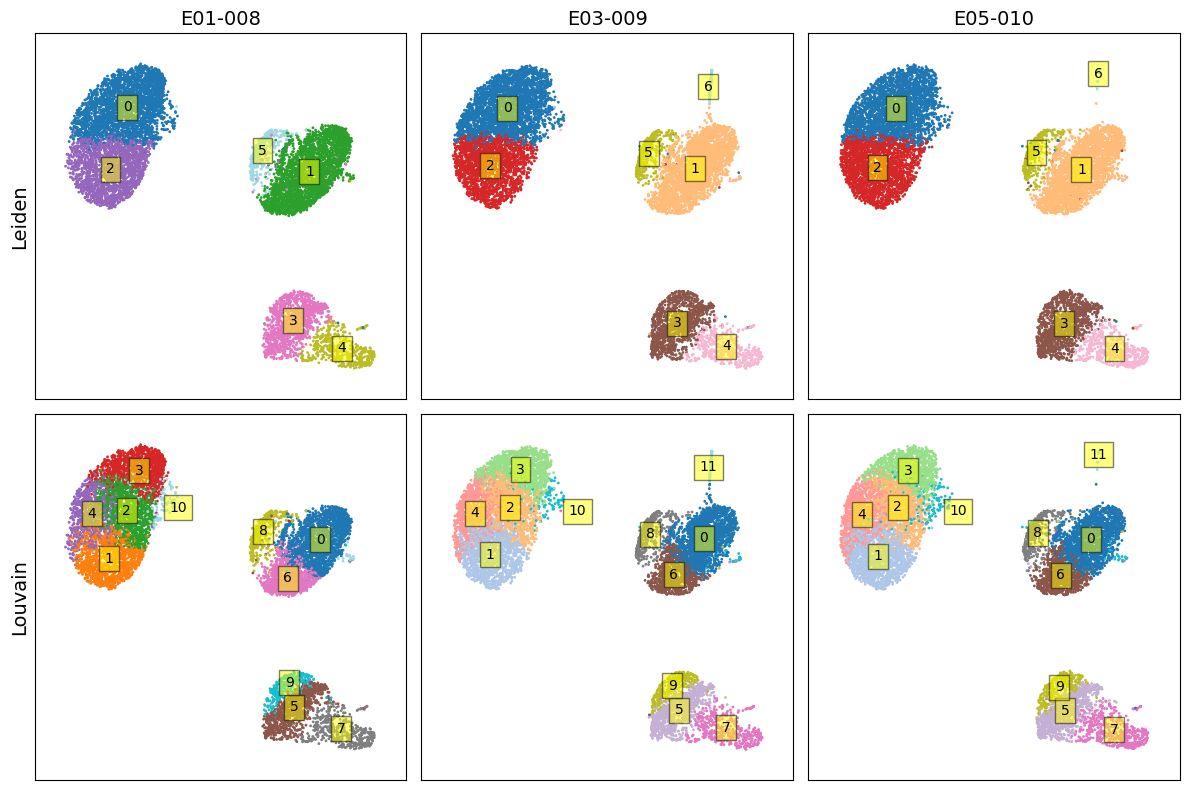

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, (community, title) in enumerate(zip(communities, titles)):
    for j in range(3):
        z = community[(j*k):(j+1)*k]
        x = X2[(j*k):(j+1)*k, 0]
        y = X2[(j*k):(j+1)*k, 1]
        
        ax = axes[i, j]
        ax.scatter(x, y, s=1, c=z, cmap='tab20')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([-0.1,1.1])
        ax.set_ylim([-0.1,1.1])
        if j==0:
            ax.set_ylabel(title, fontsize=14)
        if i==0:
            ax.set_title('-'.join(sample_ids[j].split('_')[3:5]), fontsize=14)
            
        for idx in np.unique(z):
            x_, y_ = x[z==idx], y[z==idx]
            x_c, y_c = np.mean(x_), np.mean(y_)
            
            ax.text(
                x_c, 
                y_c, 
                str(idx), 
                va='center', 
                ha='center', 
                bbox=dict(fc='yellow', alpha=0.5)
            )
            
plt.tight_layout()